In [30]:
# Practice Skills: Random forest and gradient boosting

# Goal: It is your job to predict the sales price for each house (SalePrice)

# Metric: Submissions are evaluated on RMSE between the logarithm of the 
## predicted value and the logarithm of the observed sales price.

# Submission format.

# Study guides:
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# https://www.kaggle.com/mgmarques/houses-prices-complete-solution
# https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6
    
# Dummy variables:
# https://www.youtube.com/watch?v=9yl6-HEY7_s
# https://www.youtube.com/watch?v=0s_1IsROgDc

# Categorical data:
# https://www.datacamp.com/community/tutorials/categorical-data

In [1]:
# Importing the libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import seaborn as sns
import statsmodels.api as sm 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer # separate variable into binary categories

pd.options.display.max_columns = 999 #To visualize the whole grid of columns

In [2]:
# Importing datasets:
train = pd.read_csv(r"C:\Users\rafae\Desktop\Code\Machine Learning\Kaggle - House Prices/train.csv")
print("Train data (rows, columns): " + str(train.shape))
df_train = pd.DataFrame(train)
# df_train_target = pd.DataFrame(data=train, columns=["SalePrice"])

test = pd.read_csv(r"C:\Users\rafae\Desktop\Code\Machine Learning\Kaggle - House Prices/test.csv")
print("Test data (rows, columns): " + str(test.shape))
df_test = pd.DataFrame(test)

# Dropping columns with missing, useless or repeated data:
### df_train.drop(columns=df_train["Utilities"], inplace=True)
### df_test.drop(columns=df_test["Utilities"], inplace=True)

Train data (rows, columns): (1460, 81)
Test data (rows, columns): (1459, 80)


In [4]:
# A first analysis of the data:
# # https://www.kaggle.com/mgmarques/houses-prices-complete-solution
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'skewness', 'kurtosis', corr_col ]
        
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

pd.set_option('display.max_rows', 90)
details = rstr(df_train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000000,1.882876,6.536282,1.000000
OverallQual,int64,1460,10,0,0.000000,0.216944,0.096293,0.790982
GrLivArea,int64,1460,861,0,0.000000,1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.000000,-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.000000,0.179981,0.917067,0.623431
TotalBsmtSF,int64,1460,721,0,0.000000,1.524255,13.250483,0.613581
1stFlrSF,int64,1460,753,0,0.000000,1.376757,5.745841,0.605852
FullBath,int64,1460,4,0,0.000000,0.036562,-0.857043,0.560664
TotRmsAbvGrd,int64,1460,12,0,0.000000,0.676341,0.880762,0.533723
YearBuilt,int64,1460,112,0,0.000000,-0.613461,-0.439552,0.522897


In [4]:
# Visualization of the numerical data:
display(df_train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [33]:
# df_train.info()
# df_test.columns

In [3]:
# All columns from the origianl dataframe:

df_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
# Changing a datatype:

# df_train[['MSZoning']] = df_train[['MSZoning']].astype(object)
# df_train[['MSZoning']].dtypes

In [ ]:
# The names of values of object variables:

# cat_df_train = df_train.select_dtypes(include=['object']).copy()
# print(cat_df_train['MSZoning'].value_counts())

In [8]:
# Check for duplicates:
idsUnique = len(set(df_train.Id))
idsTotal = df_train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1456 total entries


In [13]:
# Checking the results of the droppage of missing values:

df_train.drop(columns=['Id','MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'GrLivArea', 'GarageCars', 'GarageArea',
       'CentralAir', 'PavedDrive'])[:3]

,Alley,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,No,Gd,TA,No,GLQ,Unf,No,Attchd,RFn,TA,TA,No,No,No
1,No,Gd,TA,Gd,ALQ,Unf,TA,Attchd,RFn,TA,TA,No,No,No
2,No,Gd,TA,Mn,GLQ,Unf,TA,Attchd,RFn,TA,TA,No,No,No


In [31]:
# Analysis of Outliers: Boxplot:
# sns.boxplot(x=df_train['MasVnrArea'])

In [20]:
# Analysis of Outliers: Interquartile range (IQR):
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
Q1 = df_train.quantile(0.25)
Q3 = df_train.quantile(0.75)
IQR = Q3 - Q1
# print(IQR)

Text(0.5,1,'House Sales Price Distribution')

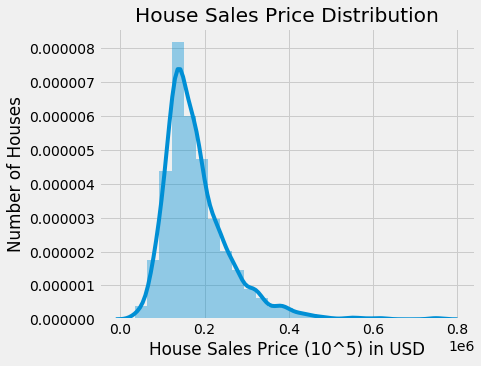

In [5]:
# SalePrice analysis:
# print(train['SalePrice'].describe())
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 5))
sns.distplot(df_train.SalePrice, bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price (10^5) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")
# sns.distplot(df_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

Skew is: 0.121335062205
Kurtosis: 0.809532


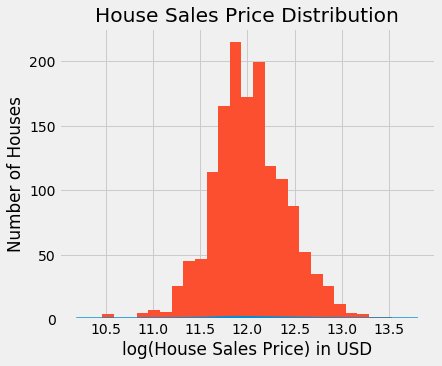

In [7]:
# log sales price to normalize it:
# https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6

plt.figure(figsize=(6,5))
sns.distplot(np.log(train.SalePrice), bins = 25)
plt.xlabel("log(House Sales Price) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")
plt.hist(np.log(train.SalePrice), bins = 25)

print("Skew is:", np.log(train.SalePrice).skew())
print("Kurtosis: %f" % np.log(train.SalePrice).kurt())

In [ ]:
#Converting SalePrice to log value:
df_train.SalePrice = np.log(df_train.SalePrice)

C:\Users\rafae\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


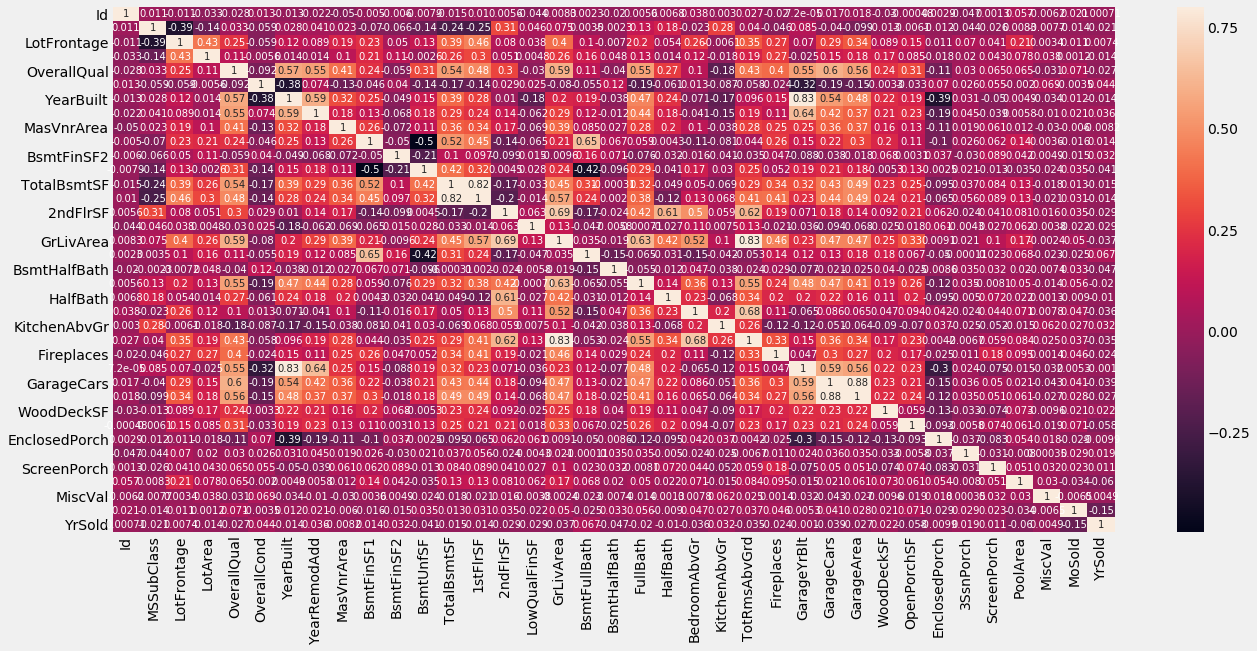

In [12]:
# Correlation Matrix:
numeric_features = df_train.select_dtypes(include=[np.number])

numeric_features.drop("SalePrice", axis = 1, inplace = True)
corr = numeric_features.corr()

f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True);

In [6]:
# Finding numeric values:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df_train.select_dtypes(include=numerics)
newdf.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [5]:
# Finding object values:
objects = ['object']
newdf2 = df_train.select_dtypes(include=objects)
newdf2.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [20]:
# Multivariate Linear Regression without data treatment:

# import statsmodels.api as sm
# from sklearn.linear_model import LinearRegression

# Below is a list of variables with only numerical values (and not year-related):
X = df_train[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold']]
y = df_train['SalePrice']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1372.
Date:                Mon, 28 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:02:49   Log-Likelihood:                -17307.
No. Observations:                1460   AIC:                         3.468e+04
Df Residuals:                    1426   BIC:                         3.486e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass     -167.2273     26.432     -6.327      0.000    -219.076    -115.378
LotFrontage       9.2093     28.494      0.323      0.747     -46.685      65.103
LotArea           0.3944      0.100      3.954      0.000       0.199       0.590
OverallQual    1.732e+04   1178.359     14.694      0.000     1.5e+04    1.96e+04
OverallCond    5096.0832   1021.550      4.989      0.000    3092.180    7099.986
YearBuilt       339.5647     60.235      5.637      0.000     221.406     457.724
YearRemodAdd    122.9546     65.960      1.864      0.063      -6.434     252.343
MasVnrArea       28.2207      5.905      4.779      0.000      16.638      39.803
BsmtFinSF1        9.5709      2.507      3.818      0.000       4.654      14.488
BsmtFinSF2        0.0812      4.470      0.018      0.986      -8.686       8.849
BsmtUnfSF        -0.5513      2.392     -0.230      0.818      -5.243       4.141
TotalBsmtSF       9.1007      3.339      2.726      0.006       2.552      15.650
1stFlrSF         18.4020      6.068      3.033      0.002       6.498      30.306
2ndFlrSF         19.7753      5.634      3.510      0.000       8.723      30.828
LowQualFinSF     -9.8001     14.682     -0.667      0.505     -38.601      19.001
GrLivArea        28.3772      5.618      5.051      0.000      17.356      39.399
BsmtFullBath   8476.9859   2586.831      3.277      0.001    3402.583    1.36e+04
BsmtHalfBath   1778.8371   4049.486      0.439      0.661   -6164.753    9722.427
FullBath       3160.2663   2793.446      1.131      0.258   -2319.439    8639.971
HalfBath      -1972.1768   2638.092     -0.748      0.455   -7147.134    3202.781
BedroomAbvGr  -1.027e+04   1678.601     -6.121      0.000   -1.36e+04   -6982.026
KitchenAbvGr  -1.571e+04   5181.911     -3.031      0.002   -2.59e+04   -5543.909
TotRmsAbvGrd   4995.3637   1226.210      4.074      0.000    2589.994    7400.733
Fireplaces     4105.3893   1755.685      2.338      0.020     661.387    7549.392
GarageYrBlt     -14.5566      2.681     -5.429      0.000     -19.816      -9.297
GarageCars     1.569e+04   2970.610      5.281      0.000    9860.275    2.15e+04
GarageArea        4.8786      9.708      0.503      0.615     -14.166      23.923
WoodDeckSF       25.8330      7.911      3.266      0.001      10.315      41.351
OpenPorchSF      -6.0105     15.032     -0.400      0.689     -35.499      23.478
EnclosedPorch    11.8945     16.690      0.713      0.476     -20.845      44.634
3SsnPorch        20.7067     31.072      0.666      0.505     -40.245      81.658
ScreenPorch      57.6505     17.026      3.386      0.001      24.251      91.050
PoolArea        -32.3946     23.440     -1.382      0.167     -78.375      13.586
MiscVal          -0.4748      1.843     -0.258      0.797      -4.089       3.140
MoSold          -28.7895    337.839     -0.085   

X_train : (1022, 36)
X_test : (438, 36)
y_train : (1022,)
y_test : (438,)
RMSE on Training set : 32119.596949
RMSE on Test set : 49147.604903


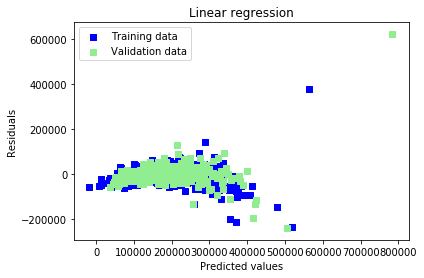

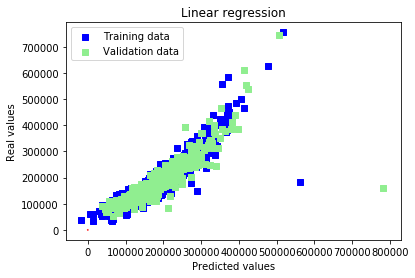

In [28]:
# Multivariate Linear Regression without data treatment (plot):
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error, make_scorer
# from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Partition the dataset in train + validation sets:
df_train_test = df_train[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold']]
X_train, X_test, y_train, y_test = train_test_split(df_train_test, y, test_size = 0.3,
                                                    random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))


# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

# Linear Regression:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set:
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [ ]:
# Analysis of individual data:

non_numeric_values = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']

# df_train["Alley"].fillna("No", inplace=True)
# df_train["BsmtQual"].fillna("No", inplace=True)
# df_train["BsmtCond"].fillna("No", inplace=True)
# df_train["BsmtExposure"].fillna("No", inplace=True)
# df_train["BsmtFinType1"].fillna("No", inplace=True)
# df_train["BsmtFinType2"].fillna("No", inplace=True)
# df_train["Fence"].fillna("No", inplace=True)
# df_train["FireplaceQu"].fillna("No", inplace=True)
# df_train["GarageType"].fillna("No", inplace=True)
# df_train["GarageFinish"].fillna("No", inplace=True)
# df_train["GarageQual"].fillna("No", inplace=True)
# df_train["GarageCond"].fillna("No", inplace=True)
# df_train["MiscFeature"].fillna("No", inplace=True)
# df_train["PoolQC"].fillna("No", inplace=True)
# df_train["LotFrontage"].fillna(0, inplace=True) # Size to 0.
# df_train["MasVnrArea"].fillna(0, inplace=True) # Area to 0.
# df_train["GarageYrBlt"].fillna(0, inplace=True) # Year to 0.

# df_train["CentralAir"].fillna("No", inplace=True)
# df_train["PavedDrive"].fillna("No", inplace=True

# Id:

In [ ]:
# "Id": It must be deleted.
# Saving the 'Id' column:
# df_train_ID = df_train['Id']
# df_test_ID = df_test['Id']

# Dropping the 'Id' column:
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

# MsSubClass:

In [4]:
# "MSSubClass": 
# The building class.
# It is a category besides being numeric.
# Correlation: -0.084284

# sns.jointplot(x="MSSubClass", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.boxplot(x="MSSubClass", y="SalePrice", data=df_train, palette="Blues")

# print(df_train['MSSubClass'].value_counts())

df_train = pd.get_dummies(df_train, columns=["MSSubClass"])

# MSZoning:

In [7]:
# 'MSZoning': 5 types of categories.
# The general zoning classification.
# It has no specific order.

# sns.boxplot(x="MSZoning", y="SalePrice", data=df_train, palette="Blues")

df_train = pd.get_dummies(df_train, columns=["MSZoning"])

# cat_df_train = df_train.select_dtypes(include=['object']).copy()
# print(cat_df_train['MSZoning'].value_counts())

### Is there any column that should be dropped for being an outlier or insignificant?

# LotFrontage:

In [9]:
# "LotFrontage": 111 types of numbers.
# Linear feet of street connected to property.
# Correlation: 0.351799

df_train["LotFrontage"].fillna(0, inplace=True) # Size to 0 or average?

# sns.jointplot(x="LotFrontage", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

### Outliers?

# Street:

In [22]:
# 'Street': 2 types of categories.
# Mostly redundant, as most streets are basically "Pave". Only 5 are "Grvl".

# df_train = pd.get_dummies(df_train, columns=["Street"]).head()
# sns.jointplot(x="Street", y="SalePrice", data=df_train, height=5, ratio=3)

## df_train.drop("Street", axis = 1, inplace = True)
## df_test.drop("Street", axis = 1, inplace = True)

# Alley:

In [12]:
# 'Alley': 3 types of categories.
# Type of alley access.

## df_train["Alley"].fillna("No", inplace=True)
## df_test["Alley"].fillna("No", inplace=True)

## df_train = df_train.replace({"Alley" : {"No" : 0, "Grvl" : 1, "Pave" : 2}})
## df_test = df_test.replace({"Alley" : {"No" : 0, "Grvl" : 1, "Pave" : 2}})

# sns.boxplot(x="", y="SalePrice", data=df_train, palette="Blues")

# df_train = pd.get_dummies(df_train, columns=["Alley"])
## df_test = pd.get_dummies(df_test, columns=["Alley"])

# LotShape:

In [16]:
# 'LotShape': 4 types of categories.

# sns.jointplot(x="", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.boxplot(x="", y="SalePrice", data=df_train, palette="Blues")

# print(df_train['']).value_counts

# df_train = pd.get_dummies(df_train, columns=[""]).head()

# LandContour:

In [80]:
# 'LandContour': 4 types of categories.
# Flatness of the property

# sns.catplot(x="LandContour", y="SalePrice", kind="box", data=df_train);

# df_train["LandContour"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["LandContour"])
## df_test = pd.get_dummies(df_test, columns=["LandContour"])

### Categorical with no order. Dummy.

# Utilities:

In [ ]:
# 'Utilities': 2 types of categories.

# sns.jointplot(x="", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.boxplot(x="", y="SalePrice", data=df_train, palette="Blues")

# print(df_train['']).value_counts

## df_train = pd.get_dummies(df_train, columns=["LandContour"])
## df_test = pd.get_dummies(df_test, columns=["LandContour"])

# LotConfig:

In [83]:
# 'LotConfig': 5 types of categories.
# Lot configuration.

# sns.catplot(x="LotConfig", y="SalePrice", kind="box", data=df_train);

# df_train["LotConfig"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["LotConfig"])
## df_test = pd.get_dummies(df_test, columns=["LotConfig"])

### Categorical without order. Dummy. Cluster FR2 and FR3?

# LandSlope:

In [86]:
# 'LandSlope': 3 types of categories.
# Slope of property.

# sns.catplot(x="LandSlope", y="SalePrice", kind="box", data=df_train);

# df_train["LandSlope"].value_counts() # Gtl: 1382 numbers.

## df_train = pd.get_dummies(df_train, columns=["LandSlope"])
## df_test = pd.get_dummies(df_test, columns=["LandSlope"])

# Neighborhood:

In [18]:
# 'Neighborhood': 25 types of categories.
# Physical locations within Ames city limits.

# result = df_train.groupby(["Neighborhood"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Neighborhood", y="SalePrice", kind="box", data=df_train, order=result["Neighborhood"]);

# df_train["Neighborhood"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["Neighborhood"])
## df_test = pd.get_dummies(df_test, columns=["Neighborhood"])

# Condition1:

In [ ]:
# 'Condition1': 9 types of categories.
# Proximity to various conditions.

# Author1: More than 80% of the houses present the Condition1 “Norm”. Maybe it 
# is a good idea to join all others in a new category.

# Author2: For this feature I am going to cluster the classes based on the class 
# description. Then, I will create dummy features.

# Condition2:

In [ ]:
# 'Condition2': 8 types of categories.
# Proximity to various conditions.

# I will then drop "Condition2" after creating a flag to indicate whether a 
# different condition from the first is nearby.

# BldgType:

In [21]:
# 'BldgType': 5 types of categories.
# Type of dwelling.

# sns.catplot(x="BldgType", y="SalePrice", kind="box", data=df_train);

# df_train["BldgType"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["BldgType"])
## df_test = pd.get_dummies(df_test, columns=["BldgType"])

# HouseStyle:

In [23]:
# 'HouseStyle': 8 types of categories.
# Style of dwelling.

# Since there are some categories with very few values, I will cluster these 
# into another category and create dummy variables.

# sns.catplot(x="HouseStyle", y="SalePrice", kind="box", data=df_train);

# df_train["HouseStyle"].value_counts()

##### Cluster and dummy

# OverallQual:

In [29]:
# 'OverallQual': 10 types of numbers.
# Rates the overall material and finish of the house.
# Correlation: 0.790982

# sns.jointplot(x="OverallQual", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.set_palette("pastel")
# sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)

### Strongly correlated. Ordinal. Maintain it as it is.

# OverallCond:

In [33]:
# 'OverallCond': 9 types of numbers.
# Rates the overall condition of the house.
# Correlation: -0.077856

# result = df_train.groupby(["OverallCond"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="OverallCond", y="SalePrice", kind="box", data=df_train, order=result["OverallCond"]);

# df_train["OverallCond"].value_counts()

### Ordinal feature, but it is not properly organized. 

#### Should I reorganize it in the proper order?

# YearBuilt:

In [40]:
# "YearBuilt": 112 types of categories/numbers (dates).
# Original construction date.
# Correlation: 0.522897

# sns.catplot(x="YearBuilt", y="SalePrice", kind="box", data=df_train);

### The newer or the older the house, the higher the correlation to SalesPrice.
### Maintain it as it is.

### Create bin and dummy for the older houses?

# YearRemodAdd:

In [36]:
# "YearRemodAdd": 61 types of categories/numbers (dates).
# Remodel date (same as construction date if no remodeling or additions).
# Correlation: 0.507101

# sns.catplot(x="YearRemodAdd", y="SalePrice", kind="box", data=df_train);

### The newer the remodelling of a house, the higher the correlation to SalesPrice.
### Maintain it as it is.

# RoofStyle:

In [48]:
# "RoofStyle": 6 types of categories.
# Type of roof.

# sns.catplot(x="RoofStyle", y="SalePrice", kind="box", data=df_train);

# df_train["RoofStyle"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["RoofStyle"])
## df_test = pd.get_dummies(df_test, columns=["RoofStyle"])

### Categorical without order. Dummies.

# RoofMatl:

In [51]:
# "RoofMatl": 8 types of categories.
# Roof material.

# sns.catplot(x="RoofMatl", y="SalePrice", kind="box", data=df_train);

# df_train["RoofMatl"].value_counts() # CompShg: 1434 values.

## df_train = pd.get_dummies(df_train, columns=["RoofMatl"])
## df_test = pd.get_dummies(df_test, columns=["RoofMatl"])

### Most features have almost no observations. Dummies to be droppped later.

# Exterior1st:

In [56]:
# "Exterior1st": 15 types of categories. 
# Exterior covering on house.

# sns.catplot(x="Exterior1st", y="SalePrice", kind="box", data=df_train);

# df_train["Exterior1st"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["Exterior1st"])
## df_test = pd.get_dummies(df_test, columns=["Exterior1st"])

# Exterior2nd:

In [55]:
# "Exterior2nd": 16 types of categories.
# Exterior covering on house.

# sns.catplot(x="Exterior2nd", y="SalePrice", kind="box", data=df_train);

# df_train["Exterior2nd"].value_counts()

### Extremely similar/correlated to Exterior1st. It will be dropped.

# MasVnrType:

In [69]:
# "MasVnrType": 5 types of categories.
# Masonry veneer type.

# sns.catplot(x="MasVnrType", y="SalePrice", kind="box", data=df_train);

# df_train["MasVnrType"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["MasVnrType"])
## df_test = pd.get_dummies(df_test, columns=["MasVnrType"])

### Categorical without order. Create dummies.

# MasVnrArea:

In [70]:
# "MasVnrArea": 328 types of numbers.
# Masonry veneer area in square feet.
# Correlation: 0.477493

## df_train["MasVnrArea"].fillna(0, inplace=True) # Area to 0.
## df_test["MasVnrArea"].fillna(0, inplace=True) # Area to 0.

# sns.jointplot(x="MasVnrArea", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["MasVnrArea"].value_counts()

### High correlation with SalesPrice. More than half the data is 0.
### Although, high correlation with MasVnrType. Drop?

# ExterQual:

In [74]:
# "ExterQual": 4 types of categories.
# Evaluates the quality of the material on the exterior.

# result = df_train.groupby(["ExterQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="ExterQual", y="SalePrice", kind="box", data=df_train, order=result["ExterQual"]);

# df_train["ExterQual"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["ExterQual"])
## df_test = pd.get_dummies(df_test, columns=["ExterQual"])

### Categorical with order. Replace it by hand?

# ExterCond:

In [76]:
# "ExterCond": 5 types of categories.
# Evaluates the present condition of the material on the exterior.

# result = df_train.groupby(["ExterCond"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="ExterCond", y="SalePrice", kind="box", data=df_train, order=result["ExterCond"]);

# df_train["ExterCond"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["ExterCond"])
## df_test = pd.get_dummies(df_test, columns=["ExterCond"])

### Categorical with order in which the order is not correlated with SalesPrice. 
### Dummy.

# Foundation:

In [42]:
# "Foundation": 6 types of categories.
# Type of foundation.

# sns.catplot(x="Foundation", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["Foundation"])
## df_test = pd.get_dummies(df_test, columns=["Foundation"])

### Categorical and not ordinal, but there is a clear order to the correlation.
### Dummy.

# BsmtCond:

In [47]:
# "BsmtCond": 5
# General condition of the basement.
# As it increases, the more increases the price.
# Ordinal Feature.

## df_train["BsmtCond"].fillna("No", inplace=True)
## df_test["BsmtCond"].fillna("No", inplace=True)

# sns.catplot(x="BsmtCond", y="SalePrice", data=df_train);

# sns.catplot(x="BsmtCond", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["BsmtCond"])
## df_test = pd.get_dummies(df_test, columns=["BsmtCond"])

# df_train.head(3)

# BsmtQual:

In [27]:
# "BsmtQual": 5 types of categories.
# Height of the basement.

## df_train["BsmtQual"].fillna("No", inplace=True)
## df_test["BsmtQual"].fillna("No", inplace=True)

# sns.catplot(x="BsmtQual", y="SalePrice", data=df_train);

# sns.catplot(x="BsmtQual", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["BsmtQual"])
## df_test = pd.get_dummies(df_test, columns=["BsmtQual"])

# df_train.head(3)

# BsmtExposure:

In [35]:
# "BsmtExposure": 5
# Walkout or garden level basement walls.
# As it increases, the more increases the price.
# Ordinal Feature.

## df_train["BsmtExposure"].fillna("No", inplace=True)
## df_test["BsmtExposure"].fillna("No", inplace=True)

# sns.catplot(x="BsmtExposure", y="SalePrice", data=df_train);

# sns.catplot(x="BsmtExposure", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["BsmtExposure"])
## df_test = pd.get_dummies(df_test, columns=["BsmtExposure"])

# df_train.head(3)

# BsmtFinType1:

In [41]:
# "BsmtFinType1": 7
# Quality of basement finished area.
# Ordinal feature, but that doesn't grow with the SalePrice.

## df_train["BsmtFinType1"].fillna("No", inplace=True)
## df_test["BsmtFinType1"].fillna("No", inplace=True)

# sns.catplot(x="BsmtFinType1", y="SalePrice", data=df_train);

# sns.catplot(x="BsmtFinType1", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["BsmtFinType1"])
## df_test = pd.get_dummies(df_test, columns=["BsmtFinType1"])

# df_train.head(3)

# BsmtFinSF1: ************************

In [3]:
# "BsmtFinSF1": 637
# Type 1 finished square feet.
# Correlation: 0.386420

# The author said that "Since this is a continuous numeric feature, I will bin 
# this into several categories and create dummy features".
# [(-4.01, 1002.5], (1002.5, 2005.0], (2005.0, 3007.5], (3007.5, 4010.0]]

# sns.jointplot(x="BsmtFinSF1", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.boxplot(x="BsmtFinSF1", y="SalePrice", data=df_train, palette="Blues")

# df_train.head(3)

# BsmtFinType2:

In [9]:
# "BsmtFinType2": 7
# Quality of second finished area (if present).

## df_train["BsmtFinType2"].fillna("No", inplace=True)

# sns.catplot(x="BsmtFinType2", y="SalePrice", data=df_train);

# sns.catplot(x="BsmtFinType2", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["BsmtFinType2"])
## df_test = pd.get_dummies(df_test, columns=["BsmtFinType2"])

# df_train.head(3)

# BsmtFinSF2: *******

In [12]:
# "BsmtFinSF2": 144
# Type 2 finished square feet.
# Correlation: -0.011378

# The author said that he will replace it with a flag.

# sns.catplot(x="BsmtFinSF2", y="SalePrice", data=df_train);

# sns.catplot(x="BsmtFinSF2", y="SalePrice", kind="box", data=df_train);

# BsmtUnfSF: ******

In [15]:
# "BsmtUnfSF": 780
# Unfinished square feet of basement area.
# Correlation: 0.214479.

# The author said "Since this is a continuous numeric feature with a significant
# correlation, I will bin this and create dummy variables".

# sns.jointplot(x="BsmtUnfSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.boxplot(x="BsmtUnfSF", y="SalePrice", data=df_train, palette="Blues")

# TotalBsmtSF: *

In [19]:
# "TotalBsmtSF": 721
# Total square feet of basement area.
# Correlation: 0.613581

# Author: "Due to this being a continuous numeric feature and also being a very 
# significant feature when describing SalePrice, I believe there could be more 
# value to be mined within this feature. Hence, I will create some binnings and 
# dummy variables".

# sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# sns.boxplot(x="TotalBsmtSF", y="SalePrice", data=df_train, palette="Blues")

# Heating:

In [10]:
# "Heating": 6
# Type of heating.

# result = df_train.groupby(["Heating"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Heating", y="SalePrice", data=df_train, order=result["Heating"]);

# result = df_train.groupby(["Heating"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Heating", y="SalePrice", kind="box", data=df_train, order=result["Heating"]);

# df_train["Heating"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["Heating"])
## df_test = pd.get_dummies(df_test, columns=["Heating"])

# HeatingQC:

In [12]:
# "HeatingQC": 5
# Heating quality and condition.

# Author: This is a categorical feature, however because it exhibits an order, 
# I will replace the values by hand with numbers.

# result = df_train.groupby(["HeatingQC"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="HeatingQC", y="SalePrice", kind="box", data=df_train, order=result["HeatingQC"]);

## df_train = pd.get_dummies(df_train, columns=["HeatingQC"])
## df_test = pd.get_dummies(df_test, columns=["HeatingQC"])

# CentralAir:

In [17]:
# "CentralAir": 2
# Central air conditioning.

## df_train["CentralAir"].fillna("No", inplace=True)

# result = df_train.groupby(["CentralAir"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="CentralAir", y="SalePrice", kind="box", data=df_train, order=result["CentralAir"]);

# df_train = pd.get_dummies(df_train, columns=["CentralAir"])
## df_test = pd.get_dummies(df_test, columns=["CentralAir"])

# df_train.head()

# Electrical:

In [24]:
# "Electrical": 6
# Electrical system.

# Author: I am going to cluster all the classes related to fuses, and the "Mix" 
# class will probably be removed during feature reduction.

## df_train["Electrical"].fillna("No", inplace=True)

# result = df_train.groupby(["Electrical"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Electrical", y="SalePrice", kind="box", data=df_train, order=result["Electrical"]);

## df_train = pd.get_dummies(df_train, columns=["Electrical"])
## df_test = pd.get_dummies(df_test, columns=["Electrical"])

# df_train.head(3)

# 1stFlrSF:

In [ ]:
# "1stFlrSF": 753
# First floor square feet.
# Correlation: 0.605852

# Author: Since this is a continuous numeric feature, once again I will bin 
# this feature and create dummy variables.

# 2ndFlrSF:

In [ ]:
# "2ndFlrSF": 417
# Second floor square feet.
# Correlation: 0.319334

# Author: Since this feature is a continuous numeric feature, I will bin this 
# and create dummy variables.

# LowQualFinSF:

In [ ]:
# "LowQualFinSF": 24
# Low quality finished square feet (all floors).
# Correlation: -0.025606

# Author: Clearly, it does not have a significant correlation with SalePrice.
# For this reason, I will replace this feature with a flag.

#### Drop?

# GrLivArea:

In [28]:
# "GrLivArea": 861

# sns.jointplot(x="SalePrice", y="GrLivArea", data=df_train, kind="reg")

# Selecting outliers (table):
df_train.drop(columns=['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']).nlargest(4, "GrLivArea")

# Removing outliers, according to the article:
deleting_outliers = df_train.drop([df_train.index[1298], df_train.index[1182], 
                                df_train.index[691], df_train.index[523]], 
                                  inplace=True)
df_train.loc[df_train["GrLivArea"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [ ]:
# "GrLivArea": 861
# Above grade ground living area in square feet.
# Correlation: 0.708624

# Author: Since this will be an important feature in our modeling, I will create
# bins and dummy features.

# BsmtFullBath:

In [ ]:
# "BsmtFullBath": 4

# Correlation: 0.227122

### For this feature and all bathrooms, it made sense to sum them all together and create a total 
# bathrooms feature.

# BsmtHalfBath:

In [ ]:
# "BsmtHalfBath": 3

# FullBath:

In [ ]:
# "FullBath": 4

# HalfBath:

In [ ]:
# "HalfBath": 3

# BedroomAbvGr:

In [21]:
# "BedroomAbvGr": 8
# Bedrooms above grade (does not include basement bedrooms).
# Correlation: 0.168213

# sns.jointplot(x="BedroomAbvGr", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# Ok.

# KitchenAbvGr:

In [23]:
# "KitchenAbvGr": 4
# Kitchens above grade.
# Correlation: -0.135907

# sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=df_train, palette="Blues")

# Ok.

# KitchenQual:

In [29]:
# "KitchenQual": 4
# Kitchen quality.

# Author: For this feature, since it is categorical with an order, I will 
# replace these values by hand.

# sns.catplot(x="KitchenQual", y="SalePrice", data=df_train);

# sns.catplot(x="KitchenQual", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["KitchenQual"])
## df_test = pd.get_dummies(df_test, columns=["KitchenQual"])

# df_train.head(3)

# TotRmsAbvGrd:

In [31]:
# "TotRmsAbvGrd": 12
# Total rooms above grade (does not include bathrooms).
# Correlation: 0.533723

# sns.jointplot(x="TotRmsAbvGrd", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# Ok.

# Functional:

In [45]:
# "Functional": 7
# Home functionality.

# sns.catplot(x="Functional", y="SalePrice", kind="box", data=df_train);

# df_train["Functional"].value_counts() # Typ = 1360 numbers.

### Typ is the most common. Cluster the rest of the data.

# Fireplaces:

In [33]:
# "Fireplaces": 4
# Number of fireplaces.
# Correlation: 0.466929

# sns.jointplot(x="Fireplaces", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# Ok.

# FireplaceQu:

In [37]:
# "FireplaceQu": 6
# Fireplace quality.

# Author: Since this is a categorical feature with order, I will replace the 
# values by hand.

## df_train["FireplaceQu"].fillna("No", inplace=True)

# sns.catplot(x="FireplaceQu", y="SalePrice", data=df_train);

# sns.catplot(x="FireplaceQu", y="SalePrice", kind="box", data=df_train);

# GarageType:

In [51]:
# "GarageType": 7
# Garage location.

## df_train["GarageType"].fillna("No", inplace=True)

# sns.catplot(x="GarageType", y="SalePrice", kind="box", data=df_train);

# df_train["GarageType"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["GarageType"])
## df_test = pd.get_dummies(df_test, columns=["GarageType"])

# GarageYrBlt:

In [55]:
# "GarageYrBlt": 98
# Year garage was built.

# Author: For this feature I am going to create bins and the dummy variables.

# df_train["GarageYrBlt"].fillna(0, inplace=True) # Year to 0.

# sns.boxplot(x="GarageYrBlt", y="SalePrice", data=df_train, palette="Blues")

## df_train = pd.get_dummies(df_train, columns=["GarageYrBlt"])
## df_test = pd.get_dummies(df_test, columns=["GarageYrBlt"])

# Bins??

# GarageFinish:

In [59]:
# "GarageFinish": 4
# Interior finish of the garage.

## df_train["GarageFinish"].fillna("No", inplace=True)

# sns.catplot(x="GarageFinish", y="SalePrice", kind="box", data=df_train);

# df_train["GarageFinish"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["GarageFinish"])
## df_test = pd.get_dummies(df_test, columns=["GarageFinish"])

# GarageCars:

In [ ]:
# "GarageCars": 5
# Size of the garage in car capacity.
# Correlation: 0.640409

# sns.boxplot(x="GarageCars", y="SalePrice", data=df_train, palette="Blues")

# df_train["GarageCars"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["GarageCars"])
## df_test = pd.get_dummies(df_test, columns=["GarageCars"])

# GarageArea:

In [61]:
# "GarageArea": 441
# Size of the garage in square feet.
# Correlation: 0.623431

# Author: This could be an important feature in the analysis, so I will bin this
# feature and create dummy variables.

# df_train["GarageArea"].value_counts()

# GarageQual:

In [64]:
# "GarageQual": 6
# Garage quality.

## df_train["GarageQual"].fillna("No", inplace=True)

# sns.catplot(x="GarageQual", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["GarageQual"])
## df_test = pd.get_dummies(df_test, columns=["GarageQual"])

# GarageCond:

In [69]:
# "GarageCond": 6
# Garage condition.

## df_train["GarageCond"].fillna("No", inplace=True)

# sns.catplot(x="GarageCond", y="SalePrice", kind="box", data=df_train);

# df_train["GarageCond"].value_counts() # TA = 1326 numbers.

## df_train = pd.get_dummies(df_train, columns=["GarageCond"])
## df_test = pd.get_dummies(df_test, columns=["GarageCond"])

# Cluster then dummy?

In [ ]:
# "PavedDrive": 3
# df_train["PavedDrive"].fillna("No", inplace=True)

# WoodDeckSF:

In [74]:
# "WoodDeckSF": 274
# Wood deck area in SF.
# Correlation: 0.324413

# sns.jointplot(x="WoodDeckSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["WoodDeckSF"].value_counts() # TA = 1326 numbers.

# Bin then dummy?

# OpenPorchSF:

In [ ]:
# "OpenPorchSF": 202
# Correlation: 0.315856

# The 4 Porch types: I will sum these features together to create a total porch 
# in square feet feature.
# I will create a flag to indicate no open porch, then I will bin the feature 
# and create dummy variables.


# EnclosedPorch:

In [ ]:
# "EnclosedPorch": 120
# Correlation: -0.128578

# 3SsnPorch:

In [ ]:
# "3SsnPorch": 20
# Correlation: 0.044584

# ScreenPorch:

In [ ]:
# "ScreenPorch": 76
# Correlation: 0.111447

# PoolArea:

In [ ]:
# "PoolArea": 8
# Pool area in square feet.

# Drop? Create a flag?

# PoolQC:

In [ ]:
# "PoolQC": 4
# Pool quality.

# df_train["PoolQC"].fillna("No", inplace=True)

# Drop

# Fence:

In [77]:
# "Fence": 5
# Fence quality.

## df_train["Fence"].fillna("No", inplace=True)

# result = df_train.groupby(["Fence"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Fence", y="SalePrice", kind="box", data=df_train, order=result["Fence"]);

# df_train["Fence"].value_counts() # 1179 with no fence.

## df_train = pd.get_dummies(df_train, columns=["Fence"])
## df_test = pd.get_dummies(df_test, columns=["Fence"])

# MiscFeature: **********

In [35]:
# "MiscFeature": 5
# Miscellaneous feature not covered in other categories.

# Author: Therefore I will drop this feature along with MiscVal.

## df_train["MiscFeature"].fillna("No", inplace=True)

# result = df_train.groupby(["MiscFeature"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="MiscFeature", y="SalePrice", kind="box", data=df_train, order=result["MiscFeature"]);

# df_train["MiscFeature"].value_counts() # 1406 missing values.

###### Drop???

# MiscVal:

In [33]:
# "MiscVal": 21

# Author: Therefore I will drop this feature along with MiscVal.

# result = df_train.groupby(["MiscVal"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="MiscVal", y="SalePrice", kind="box", data=df_train, order=result["MiscVal"]);

# df_train["MiscVal"].value_counts() # 1408 missing values.

###### Drop???

# MoSold:

In [38]:
# "MoSold": 12
# Month sold (MM).
# Correlation: 0.046432

# train = train.replace({"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 
#                                   5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug", 
#                                   9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
#                      })

# sns.catplot(x="MoSold", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["MoSold"])
## df_test = pd.get_dummies(df_test, columns=["MoSold"])

# Just dummies?

# YrSold:

In [40]:
# "YrSold": 5
# Year sold (YYYY).
# Correlation: -0.028923

# sns.catplot(x="YrSold", y="SalePrice", kind="box", data=df_train);

## df_train = pd.get_dummies(df_train, columns=["YrSold"])
## df_test = pd.get_dummies(df_test, columns=["YrSold"])

# Just dummies?

# SaleType:

In [44]:
# "SaleType": 9
# Type of sale.

# Author: For this feature, I will cluster some categories together and then 
# create dummy features.

# result = df_train.groupby(["SaleType"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="SaleType", y="SalePrice", kind="box", data=df_train, order=result["SaleType"]);

# df_train["SaleType"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["SaleType"])
## df_test = pd.get_dummies(df_test, columns=["SaleType"])

# Cluster data and create dummy?

# SaleCondition:

In [47]:
# "SaleCondition": 6
# Condition of sale.

# result = df_train.groupby(["SaleCondition"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="SaleCondition", y="SalePrice", kind="box", data=df_train, order=result["SaleCondition"]);

# df_train["SaleCondition"].value_counts()

## df_train = pd.get_dummies(df_train, columns=["SaleCondition"])
## df_test = pd.get_dummies(df_test, columns=["SaleCondition"])

In [ ]:
# Searching for missing values in the data
df_train['GarageYrBlt'].isna().values.any()

# Searching for missing values in the data
df_train['GarageYrBlt'].isna().sum()